# Single cell level analysis, B cells

**Top Note:** we should consider normalise the library size (labelled as `exp_sum_count` or `total_counts`) with predefined coefficient weight as 1.

$$y \sim NB(\mu, \phi)$$
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$

You may use your implemement and fit this parameter (it should be close enough to 1) or use 
[statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html)
by setting it as `exposure`:

```Python
NB_glm = sm.discrete.discrete_model.NegativeBinomial(
    obs_y, feature_x,                                                         
    loglike_method = 'nb2', 
    exposure = sample_libsize, 
    offset = None, 
    missing = 'none', 
    check_rank = True
)
```

For negative binomial likelihood, check [aod R package](https://rdrr.io/cran/aod/man/negbin.html).

In [14]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.io import mmread
from statsmodels.discrete.discrete_model import NegativeBinomial
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../NegabinGLM')

import NegativeBinomial as NB

In [15]:
# create a repository for the data
!mkdir ../write_data/write_data_cell_B
path = '../write_data/write_data_cell_B/'

mkdir: ../write_data/write_data_cell_B: File exists


## Load genes

In [16]:
df_genes = pd.read_csv('../data/NPC_NLH-genes.tsv', sep='\t')
df_genes

,gene_names,gene_ids
0,HES5,ENSG00000197921
1,TP73,ENSG00000078900
2,HES2,ENSG00000069812
3,PAX7,ENSG00000009709
4,E2F2,ENSG00000007968
...,...,...
614,OLIG1,ENSG00000184221
615,RUNX1,ENSG00000159216
616,ERG,ENSG00000157554
617,ETS2,ENSG00000157557


## Load sc level B cells

In [17]:
Y_cell_B_mat = mmread('../data/NPC_NLH-Bcell-Y.mtx')
Y_cell_B = Y_cell_B_mat.A
Y_cell_B.shape

(24296, 619)

In [18]:
# create a df using Y_cell_B, and add gene names as column names
df_Y_cell_B = pd.DataFrame(Y_cell_B)
df_Y_cell_B.columns = df_genes['gene_names']

# change column 'gene_names' to 'idx'
df_Y_cell_B = df_Y_cell_B.rename(columns={'gene_names': 'idx'})
df_Y_cell_B

gene_names,HES5,TP73,HES2,PAX7,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,...,TEF,SREBF2,GABPA,BACH1,OLIG2,OLIG1,RUNX1,ERG,ETS2,PKNOX1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24292,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
24293,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
24294,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
Y_cell_B = df_Y_cell_B

In [20]:
X_cell_B = pd.read_csv('../data/NPC_NLH-Bcell-X.tsv', sep='\t')
X_cell_B

,cell_id,patient_ID,condition,exp_sum_count
0,GCATGTAGTCTAGTCA-4,4,NPC,2497.0
1,TAAGAGAAGGAGTCTG-5,5,NPC,2590.0
2,CCGTACTCAGACAAAT-4,4,NPC,2247.0
3,TTGCCGTTCAACCATG-4,4,NPC,1596.0
4,GAGTCCGCATCGGTTA-12,12,NLH,7943.0
...,...,...,...,...
24291,TGGTTAGTCCGTAGGC-11,11,NLH,2813.0
24292,CCTTTCTGTACTTAGC-9,9,NPC,4092.0
24293,CAGCTGGTCGCCTGAG-4,4,NPC,2975.0
24294,CGGTTAACAGGCGATA-9,9,NPC,6340.0


filter gene with 0 total counts

In [21]:
# filter out genes with zero counts in all cells
Y_cell_B = Y_cell_B.loc[:, (Y_cell_B != 0).any(axis=0)]
Y_cell_B

gene_names,HES5,TP73,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,NFYC,FOXO6,...,MAFF,ATF4,TEF,SREBF2,GABPA,BACH1,RUNX1,ERG,ETS2,PKNOX1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24291,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24292,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
24293,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
24294,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


change condition to binary

In [22]:
# add a binary condition column, 1 for NPC, 0 for NLH
X_cell_B['condition_bi'] = np.where(X_cell_B['condition']=='NPC', 1, 0)
X_cell_B['log_tc'] = np.log(X_cell_B['exp_sum_count'])
X_cell_B

,cell_id,patient_ID,condition,exp_sum_count,condition_bi,log_tc
0,GCATGTAGTCTAGTCA-4,4,NPC,2497.0,1,7.822845
1,TAAGAGAAGGAGTCTG-5,5,NPC,2590.0,1,7.859413
2,CCGTACTCAGACAAAT-4,4,NPC,2247.0,1,7.717351
3,TTGCCGTTCAACCATG-4,4,NPC,1596.0,1,7.375256
4,GAGTCCGCATCGGTTA-12,12,NLH,7943.0,0,8.980046
...,...,...,...,...,...,...
24291,TGGTTAGTCCGTAGGC-11,11,NLH,2813.0,0,7.942007
24292,CCTTTCTGTACTTAGC-9,9,NPC,4092.0,1,8.316789
24293,CAGCTGGTCGCCTGAG-4,4,NPC,2975.0,1,7.997999
24294,CGGTTAACAGGCGATA-9,9,NPC,6340.0,1,8.754634


In [23]:
X_cell_B_NB1 = X_cell_B[['condition_bi', 'log_tc']] # X of L1, NB model
X_cell_B_NB0 = X_cell_B[['log_tc']] # X of L0, NB model

X_cell_B_NB0 = sm.add_constant(X_cell_B_NB0)
X_cell_B_NB1 = sm.add_constant(X_cell_B_NB1)

In [24]:
X_cell_B_NB0

,const,log_tc
0,1.0,7.822845
1,1.0,7.859413
2,1.0,7.717351
3,1.0,7.375256
4,1.0,8.980046
...,...,...
24291,1.0,7.942007
24292,1.0,8.316789
24293,1.0,7.997999
24294,1.0,8.754634


Fit NegBin models 

L1:
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$
L0 (NULL): 
$$\log(\mu) = w_0 * 1 + 1 * total\_counts$$

The `llr_pvalue` is the p value of the log likelihood ratio test on L0 and L1

In [25]:
ll0_cell_B = np.zeros(Y_cell_B.shape[1])
ll1_cell_B = np.zeros(Y_cell_B.shape[1])

NB_Reg module

In [26]:
for i in range(Y_cell_B.shape[1]):

    Y_genes = Y_cell_B.iloc[:, i]

    L1_NB = NB.NB_Reg(X_cell_B_NB1, Y_genes)
    L0_NB = NB.NB_Reg(X_cell_B_NB0, Y_genes)
    
    L1_NB.fit_w_exp()
    L0_NB.fit_w_exp()
    L1_NB.fit_phi()
    L0_NB.fit_phi()

    ll0_cell_B[i] = -1 * L0_NB.optimize_record_phi.fun
    ll1_cell_B[i] = -1 * L1_NB.optimize_record_phi.fun

    if i % 50 == 0:
        print(i)

0


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma

50


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: Runtime

100


/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getat

150


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getat

200


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid 

250


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Use

300


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma

350


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getat

400


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma

450


/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encountered in power
  ll = np.sum(np.log((gamma(Y+phi)/((gamma(Y+1)*gamma(phi))))*((phi/(phi+mu))**phi)*((mu/(phi+mu))**Y)))
/Users/qiaojiamu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/qiaojiamu/NegabinGLM/notebooks/../NegabinGLM/NegativeBinomial.py:36: RuntimeWarning: invalid value encount

LRT

In [27]:
lrt_statistic_cell_B = 2 * (ll1_cell_B - ll0_cell_B)
p_val_cell_B = sp.stats.chi2.sf(lrt_statistic_cell_B, 1)
p_val_cell_B

array([7.74820573e-001, 4.19909059e-002, 2.26180872e-001, 1.00000000e+000,
       9.49130387e-001, 1.00000000e+000, 3.32987607e-001, 8.76500029e-001,
       1.00000000e+000, 5.55271848e-002, 5.26547528e-002, 3.60736865e-001,
       1.00000000e+000, 2.82654924e-001, 4.68762504e-003, 8.00477751e-002,
       1.00000000e+000, 7.60652581e-001, 2.54012008e-004, 4.99316309e-005,
       1.40415065e-009, 0.00000000e+000, 1.61448823e-001, 9.51023817e-001,
       2.89012272e-003, 3.33706182e-001, 3.11897253e-001, 2.34390236e-003,
       1.95284732e-022, 4.32622708e-002, 3.12216500e-001, 4.35208665e-001,
       1.13732281e-001, 7.70156918e-002, 8.61582647e-001, 6.47576246e-002,
       0.00000000e+000, 1.00000000e+000, 1.00000000e+000, 2.57994568e-011,
       0.00000000e+000, 6.02946880e-028, 1.35940184e-001, 2.59401554e-001,
       0.00000000e+000, 2.19357036e-005, 3.48481902e-001, 1.89493955e-003,
       1.48376777e-001, 5.53791665e-136, 7.96424535e-002, 3.12226026e-001,
       3.12220044e-001, 1

In [28]:
p_val_cell_B.shape

(474,)

In [29]:
from statsmodels.stats.multitest import fdrcorrection
p_val_corrected_cell_B = fdrcorrection(p_val_cell_B, alpha=0.05, method='indep', is_sorted=False)[1]
p_val_corrected_cell_B.shape

(474,)

In [30]:
# create a dataframe, store gene names, p values, and corrected p values
# use gene names from Y_cell_B
df_pval_cell_B = pd.DataFrame({'gene': Y_cell_B.columns, 'p_val': p_val_cell_B, 'p_val_corrected': p_val_corrected_cell_B})

In [31]:
# rank genes by p_val_corrected, ascending order
df_pval_cell_B = df_pval_cell_B.sort_values(by=['p_val_corrected'])
df_pval_cell_B

,gene,p_val,p_val_corrected
405,ZNF317,0.000000,0.0
92,KLF3,0.000000,0.0
387,PLAGL2,0.000000,0.0
21,ETV3,0.000000,0.0
129,PBX2,0.000000,0.0
...,...,...,...
303,HIF1A,1.000000,1.0
304,ESR2,1.000000,1.0
98,LEF1,0.791306,1.0
97,NFKB1,1.000000,1.0


Plot the distribution of corrected p values

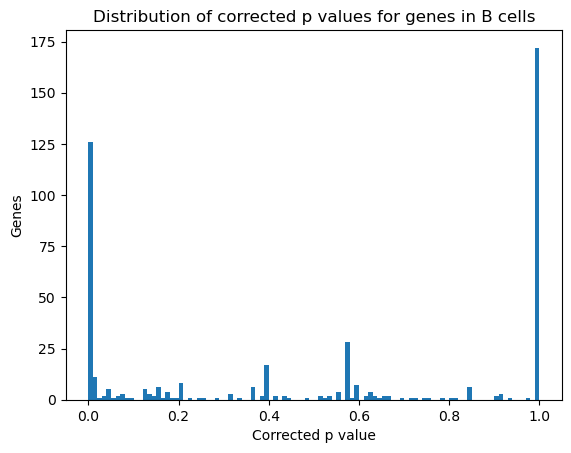

In [42]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_cell_B), len(df_pval_cell_B))
plt.hist(df_pval_cell_B['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in B cells')
plt.savefig(path + 'p_val_corrected_cell_B.png')
plt.show()

In [43]:
# filter genes with corrected p value = 1
df_pval_cell_B_filtered = df_pval_cell_B[df_pval_cell_B['p_val_corrected'] != 1]
df_pval_cell_B_filtered

,gene,p_val,p_val_corrected
405,ZNF317,0.000000,0.000000
92,KLF3,0.000000,0.000000
387,PLAGL2,0.000000,0.000000
21,ETV3,0.000000,0.000000
129,PBX2,0.000000,0.000000
...,...,...,...
444,ZNF784,0.573938,0.912908
85,SOX2,0.581112,0.918158
103,FOXD1,0.581046,0.918158
200,OSR2,0.596122,0.938743


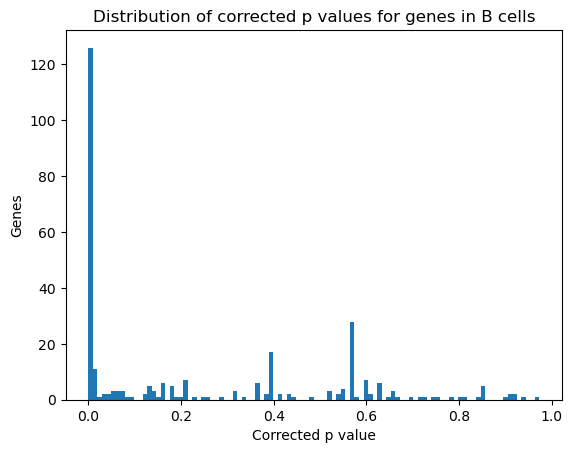

In [44]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_cell_B_filtered), len(df_pval_cell_B_filtered))
plt.hist(df_pval_cell_B_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in B cells')
plt.show()

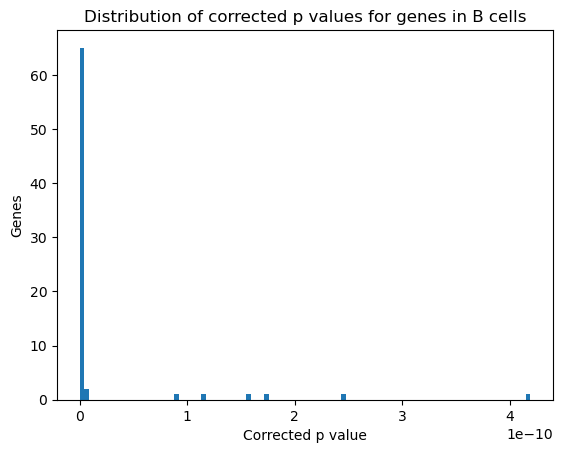

In [45]:
df_pval_cell_B_filtered = df_pval_cell_B_filtered[df_pval_cell_B_filtered['p_val_corrected'] < 0.000000001]
genes = np.linspace(1, len(df_pval_cell_B_filtered), len(df_pval_cell_B_filtered))
plt.hist(df_pval_cell_B_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in B cells')
plt.savefig(path + 'p_val_corrected_cell_B_filtered.png')
plt.show()

In [46]:
top_genes_cell_B = df_pval_cell_B_filtered[df_pval_cell_B_filtered['p_val_corrected'] < 1e-10]
top_genes_cell_B

,gene,p_val,p_val_corrected
405,ZNF317,0.000000e+00,0.000000e+00
92,KLF3,0.000000e+00,0.000000e+00
387,PLAGL2,0.000000e+00,0.000000e+00
21,ETV3,0.000000e+00,0.000000e+00
129,PBX2,0.000000e+00,0.000000e+00
...,...,...,...
207,HSF1,1.273863e-13,9.434550e-13
202,TRPS1,4.141131e-13,3.019840e-12
429,POU2F2,8.141301e-13,5.846934e-12
264,VDR,1.020885e-12,7.222380e-12


In [47]:
# find df_cell_B columns that correspond to the top genes, keep condition
df_cell_B_top_genes = Y_cell_B[top_genes_cell_B['gene']]
df_cell_B_top_genes['condition'] = X_cell_B['condition']
# move condition column to the front
cols = df_cell_B_top_genes.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_cell_B_top_genes = df_cell_B_top_genes[cols]
# change 'gene_names' to 'idx'
df_cell_B_top_genes = df_cell_B_top_genes.rename(columns={'gene_names': 'idx'})
df_cell_B_top_genes #final top gene result

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_24099/2966666006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell_B_top_genes['condition'] = X_cell_B['condition']


gene_names,condition,ZNF317,KLF3,PLAGL2,ETV3,PBX2,ZBTB18,ZNF354A,KLF11,SREBF1,...,ELF1,MZF1,HOXB7,CEBPB,FOXP3,HSF1,TRPS1,POU2F2,VDR,RELA
0,NPC,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
1,NPC,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,NPC,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,NLH,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24291,NLH,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24292,NPC,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,1,0,1
24293,NPC,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24294,NPC,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [48]:
# save the top genes to a tsv file
df_cell_B_top_genes.to_csv(path + 'NPC_NLH_cell_B_top_genes.tsv', sep='\t')
top_genes_cell_B.to_csv( path + 'NPC_NLH_cell_B_top_genes_ranking.tsv', sep='\t')

heatmap

In [49]:
# add total_counts column, total_counts = sum of counts of all genes
df_cell_B_top_genes['total_counts'] = df_cell_B_top_genes.sum(axis=1)
df_cell_B_top_genes

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_24099/2675691818.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cell_B_top_genes['total_counts'] = df_cell_B_top_genes.sum(axis=1)


gene_names,condition,ZNF317,KLF3,PLAGL2,ETV3,PBX2,ZBTB18,ZNF354A,KLF11,SREBF1,...,MZF1,HOXB7,CEBPB,FOXP3,HSF1,TRPS1,POU2F2,VDR,RELA,total_counts
0,NPC,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,6
1,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,NPC,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,6
3,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,3
4,NLH,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24291,NLH,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5
24292,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,12
24293,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
24294,NPC,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2,0,0,17


In [50]:
# sum the counts of the top genes for condition NPC and NLH, normalize each gene
df_cell_B_top_genes_heatmap = df_cell_B_top_genes.groupby('condition').sum()
# normalize each gene by dividing each gene by total_counts
df_cell_B_top_genes_heatmap = df_cell_B_top_genes_heatmap.div(df_cell_B_top_genes_heatmap['total_counts'], axis=0)
# drop total_counts column
df_cell_B_top_genes_heatmap = df_cell_B_top_genes_heatmap.drop(columns=['total_counts'])
df_cell_B_top_genes_heatmap

gene_names,ZNF317,KLF3,PLAGL2,ETV3,PBX2,ZBTB18,ZNF354A,KLF11,SREBF1,PRDM1,...,ELF1,MZF1,HOXB7,CEBPB,FOXP3,HSF1,TRPS1,POU2F2,VDR,RELA
condition,,,,,,,,,,,,,,,,,,,,,
NLH,0.006897,0.008660,0.003827,0.006860,0.005472,0.002311,0.004640,0.001690,0.003581,0.010249,...,0.099038,0.006650,0.000987,0.003416,0.000429,0.035086,0.003371,0.172591,0.000703,0.033725
NPC,0.005880,0.006339,0.003704,0.005278,0.005556,0.002643,0.004005,0.001671,0.003185,0.016292,...,0.096059,0.006979,0.002695,0.006663,0.002515,0.034090,0.002537,0.169201,0.002085,0.033074


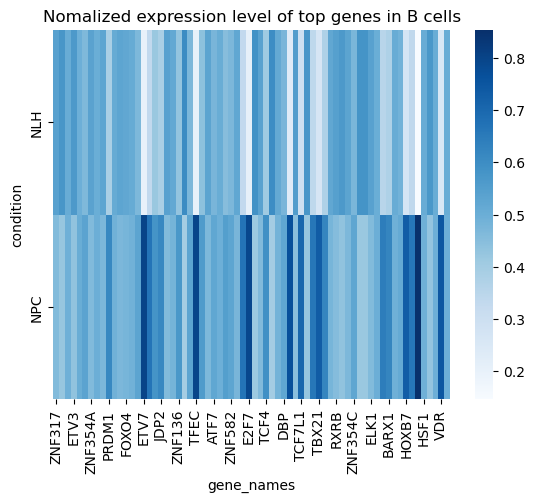

In [51]:
# normalize each gene by dividing each gene by the sum of the column
df_cell_B_top_genes_heatmap = df_cell_B_top_genes_heatmap.div(df_cell_B_top_genes_heatmap.sum(axis=0), axis=1)

# heatmap
sns.heatmap(df_cell_B_top_genes_heatmap, cmap='Blues')
plt.title('Nomalized expression level of top genes in B cells')
plt.savefig(path + 'top_genes_cell_B_heatmap.png')
plt.show()